# Quick primer on elections 

## Categories of vote

**Abstention**: The ballot expresses no preference, i.e., it is blank.


**Illegal**: The ballot expresses a preference which cannot be satisfied within the bounds of the election.
        
        In this election, this could involve:    
        - The voter writing-in a name which they also selected.
      
        Back when we conducted the election via Canvas, we also had to worry about:
        - The voter selecting more than the allowed number of candidates 
        - Selecting the maximum number and then writing in an additional candidate.

**Cast** = abstentions + legal + illegal
    
    - Cast plays no role except for auditing 

**Valid** = legal + illegal
    
    - These determine the denominator when a position requires a majority (i.e., > 50%)
    
    - Note that abstentions do not count in the denominator



__ TOOLS FOR MANAGING THE ELECTION. NOT FOR REPORTING. __

2019!

In [12]:
%cd ~/Dropbox/csun-election-management


#Plotting 
%matplotlib inline
from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set(style="whitegrid")

#Base Classes stuff
from FileSystemTools import *
from UtilityDecorators import *
from UtilityFunctions import *

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import counter.environment as env
from counter.QualitricsHelpers import get_results_column_names, get_write_in_column_names
from counter.QualitricsProcessors import process_results, save_results, process_field, process_voter, process_office_columns
from counter.FileSystemTools import makeDataFileList
# String processing of result cells
from counter.StringProcessors import find_dept, remove_depts

/Users/adam/Dropbox/csun-election-management


# Load and process data

## Get results file

In [13]:
results_files = [f for f in makeDataFileList(env.INPUT_FOLDER_PATH) if f[-3:] == 'csv']
data = pd.read_csv(results_files[0])

## Remove non-response rows

In [14]:
dropped = data[data.index <= 1]
data = data[data.index > 1]

## Remove unneded columns

In [15]:
drop_columns = ['DistributionChannel', 'UserLanguage', 'Status' ]
data.drop(drop_columns, axis=1, inplace=True)
data.dropna(how='all', axis=0, inplace=True)

## Set timestamps

In [35]:
# Voting dates
date_fields = ['StartDate', 'EndDate', 'RecordedDate']
def make_ts(row):
    return pd.to_datetime(row[date_fields])
data[date_fields] = data.apply(lambda x: make_ts(x), axis=1)

## Process the data

In [5]:
from counter.Exceptions import OfficeProcessingError
from counter.DataObjects import OfficeElection
from counter.Definitions import OfficeDefinitions

# Read in the properties of the various offices
Definitions = OfficeDefinitions()

def process_results(frame):
    """This is the master processing function
    Returns a list of results objects for each office where no errors
    were encountered.
    """
    results = []
    
    results_columns = get_results_column_names(frame)
    for c in results_columns:
        # create a data store object
        office_name = Definitions.get_office_name_for_field(c)
        requires_maj = Definitions.office_requires_majority(c)
        write_in_columns = get_write_in_column_names(frame, c)
        r = OfficeElection(officeName=office_name, 
                           fieldName=c, 
                           writeInFieldNames=write_in_columns,
                          requires_majority=requires_maj
                          )
        # it will pull out the relevant columns
        r.add_data(frame)
        try:
            office_counts = process_office_columns(r)
            results.append(r)
        except OfficeProcessingError as err:
            # These blocked the results object from being added to the 
            # results list
            print("Error proccessing office: {}".format(office_name))
            for e in err.errors:
                print(e)
    return results


def save_results(output_file, results):
    """Writes results to output file"""
    with pd.ExcelWriter(output_file) as writer:
        for result in results:
#             print("Writing results of {} to file".format(result.officeName))
            result.vote_counts.to_excel(writer, sheet_name=result.officeName)


In [16]:
results = process_results(data)
# save_results(env.OUTPUT_FILE, results)

# Results !

## Vote counts and percentage of total valid votes

NB, Officers of the Faculty and the Statewide Senator must be elected by a majority of votes. Thus for these offices we need a run off if 'pct_of_valid' is not greater than %50 for one candidate. 

I've nonetheless included the percentage of valid votes for all other offices in case it is of interest.

In [17]:
from IPython.display import display, Math, Latex, HTML

for r in results:
    out = """\\begin{figure}
    \\caption{%s}
    %s
    \\end{figure}""" % (r.officeName, r.combined_results_frame.T.to_latex())
    display(Latex(out))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Visualized

Here's the results data in chart form (sorry, it was too much of a pain to integrate these with the tables)

Again, the plots in the column on the right are unnecessary for senators-at-large and standing committees.

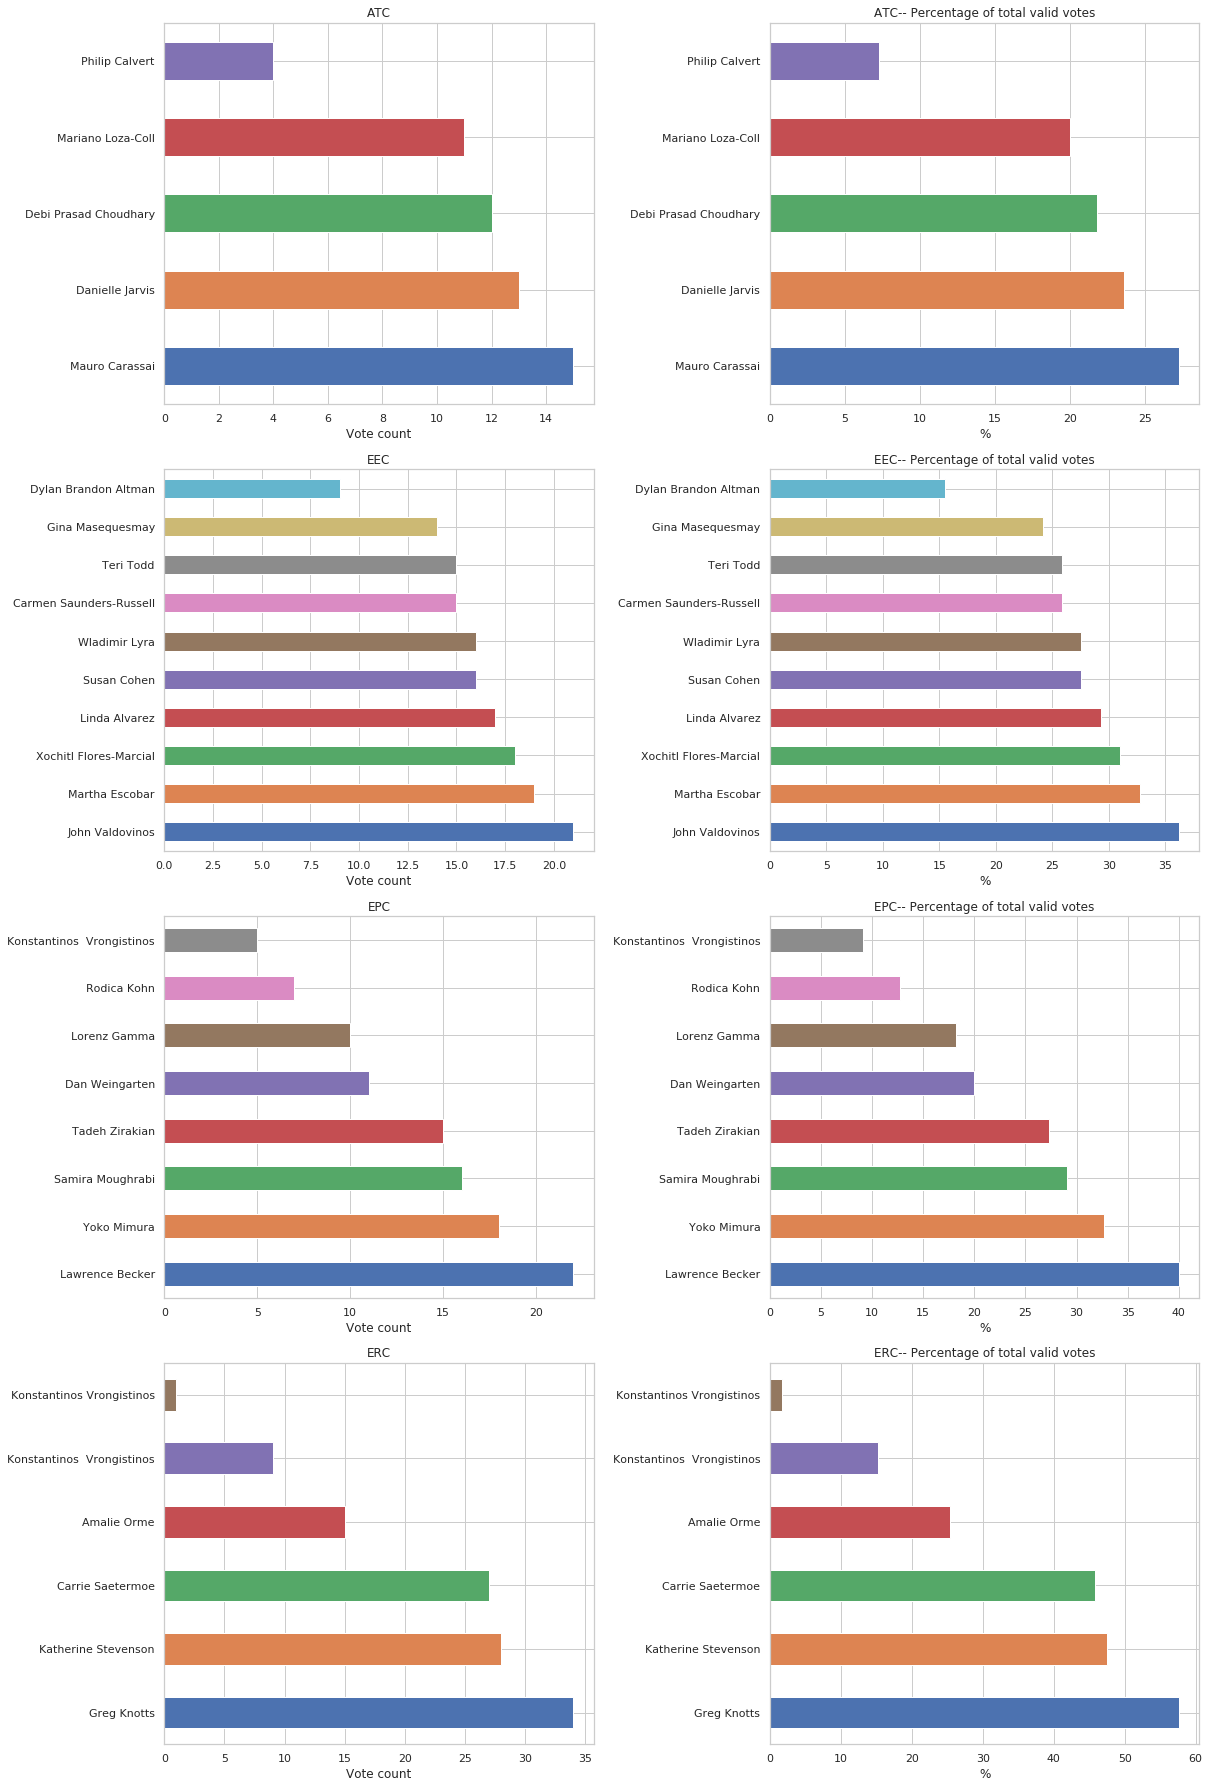

In [18]:
n = round(len(results)/2)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(17,25))
row = 0; col=0
for r in results[:n]:
    r.vote_counts.plot(kind='barh', title=r.officeName, ax=axes[row, 0])
    axes[row, 0].set_xlabel("Vote count")
    r.percentages_of_valid.plot(kind='barh', title=r.officeName + "-- Percentage of total valid votes", ax=axes[row, 1])
    axes[row, 1].set_xlabel("%")
    row +=1
fig.tight_layout()

For the ERC election, note that Dino's name had 2 spaces in between his first and last name on the ballot. The folks who chose to write his name in rather than selecting it added 1 space, thus my program didn't combine them.


## Abstentions

It's worth looking briefly at abstentions. Those on the Senate know my militant view on abstentions. Holes are privations of dirt. Abstentions are privations of votes.^. 

This fits with the Robert's Rules treatment of abstentions, which governs our elections: only ballots which indicate a preference count toward vote totals. Writing in 'Anyone but these yahoos' expresses a preference. A blank ballot expresses the absence of a preference. Therefore, abstentions do not count in the denominator for offices which require the winner to obtain a majority.

There's not much to be learned from the amount of abstentions ---we cannot infer that voters hated all the candidates since it could've been that they loved them all equally.^^ But, for completeness, here they are: 


^ Technically, they exist but do not subsist

^^ For arguments that it isn't always rational to flip a coin in these cases, see (my former teacher) Ruth Chang's work on incommensurable values

In [16]:
d = []
for r in results:
    d.append({r.officeName : r.number_abstentions})
abst = pd.DataFrame(d)
display(Latex(abst.to_latex()))

<IPython.core.display.Latex object>

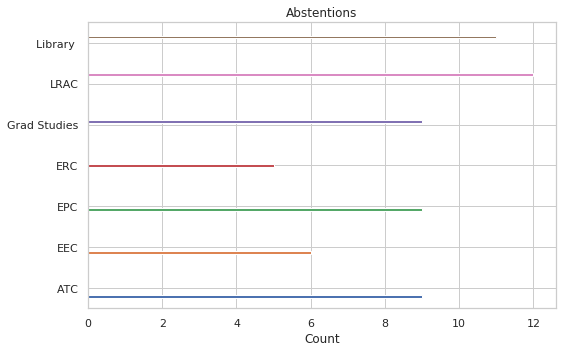

In [25]:
fig, axes = plt.subplots(figsize=(8,5))
abst.T.plot(kind='barh', title='Abstentions', ax=axes)
axes.get_legend().remove()
# axes.legend(loc=9, ncol=7, mode='expand', borderaxespad=0.)
axes.set_xlabel("Count")
fig.tight_layout()

# General properties of the election

## Total votes cast

In [26]:
cast = []
for r in results:
    cast.append({r.officeName : r.cast_votes})
cast = pd.DataFrame(cast)
display(Latex(cast.to_latex()))

<IPython.core.display.Latex object>

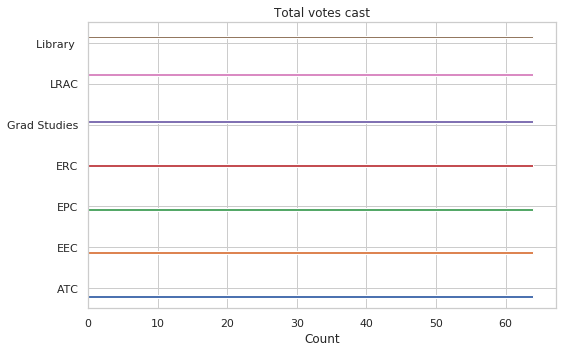

In [29]:
fig, axes = plt.subplots(figsize=(8,5))
cast.T.plot(kind='barh', title='Total votes cast', ax=axes)
axes.get_legend().remove()
axes.set_xlabel("Count")
fig.tight_layout()

## Proportion of eligible voters

In [21]:
eligible = pd.read_excel(env.ELIGIBILITY_FILE_PATH)
eligible.set_index('year', inplace=True)

In [22]:
eligible

,general,standing_committees
year,,
2012,932,NaN
2013,957,NaN
2014,962,NaN
2015,970,70.0
2016,1036,69.0
2017,1013,69.0
2018,1004,71.0
2019,998,73.0


## Daily marginal votes cast

In [23]:
d= data.copy(deep=True)
d.set_index('RecordedDate', inplace=True)

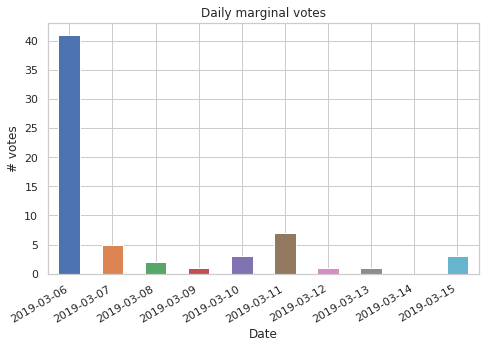

In [24]:
fig, axes = plt.subplots(figsize=(7,5))
d.resample('D')['ResponseId'].count().plot(kind='bar', ax=axes)
axes.set_ylabel('# votes'); axes.set_title("Daily marginal votes"); axes.set_xlabel('Date')
xtl=[item.get_text()[:10] for item in axes.get_xticklabels()]
_=axes.set_xticklabels(xtl)
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
fig.tight_layout()

In [32]:
i = 0
for v in d.resample('D')['ResponseId'].count():
    print(senateData.columns[i], v)
    senateData.loc[2019][senateData.columns[i]] = v
    i += 1

Day 1 41
Day 2 5
Day 3 2
Day 4 1
Day 5 3
Day 6 7
Day 7 1
Day 8 1
Day 9 0
Day 10 3


In [58]:
d.resample('D')['ResponseId'].count().cumsum()


RecordedDate
2019-03-06    41
2019-03-07    46
2019-03-08    48
2019-03-09    49
2019-03-10    52
2019-03-11    59
2019-03-12    60
2019-03-13    61
2019-03-14    61
2019-03-15    64
Freq: D, Name: ResponseId, dtype: int64

In [70]:
def load_past_returns(election_type):
    # Load the correct df
    sheet = "Data-{}".format(election_type.lower())
#     sheet = 'Data-senate' if election_type == 'senate' else 'Data-general'
    pastData = pd.read_excel(env.PAST_RETURNS_FILE_PATH, sheet_name=sheet)
    pastData.set_index('Year', inplace=True)
    return pastData

def update_returns(frame_w_timestamp_index, election_type, year, save=False):
    """Adds the daily cumulative sum of vote counts for the presesnt year to the
    data for past years"""
    past = load_past_returns(election_type)
    # Calcluate marginal votes for present year and add
    i = 0
    for v in frame_w_timestamp_index.resample('D')['ResponseId'].count().cumsum():
        past.loc[year, past.columns[i]] = v
        i += 1
    if save:
        sheet = "Data-{}".format(election_type.lower())
        past.to_excel(env.PAST_RETURNS_FILE_PATH, sheet_name=sheet)
    return past


In [71]:
d = data.set_index('RecordedDate')
returns = update_returns(d, 'senate', 2019, True)
returns.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
returns.dropna(axis=1, how='all', inplace=True)

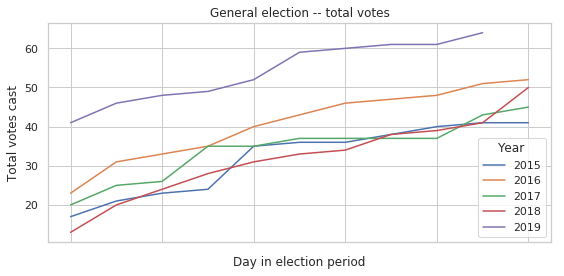

In [61]:
t = "General election"
fig, axes = plt.subplots(figsize=(8,4))
returns.T.plot(ax=axes)
axes.set_title("%s -- total votes" % t)
axes.set_ylabel("Total votes cast"); axes.set_xlabel("Day in election period")
fig.tight_layout()

In [63]:
def calc_proport_of_eligible(frame, year, total):
    numEligible = frame.loc[year]
    return total / numEligible

returnsProport = returns.apply(lambda x : calc_proport_of_eligible(eligible['standing_committees'], x.index, x))

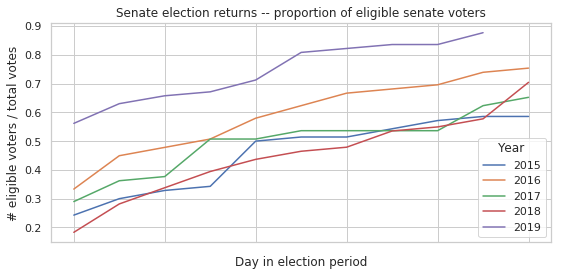

In [65]:
fig, axes = plt.subplots(figsize=(8,4))
returnsProport.T.plot(ax=axes)
axes.set_title("Senate election returns -- proportion of eligible senate voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

In [64]:
returnsProport

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11
Year,,,,,,,,,,,
2015,0.242857,0.300000,0.328571,0.342857,0.500000,0.514286,0.514286,0.542857,0.571429,0.585714,0.585714
2016,0.333333,0.449275,0.478261,0.507246,0.579710,0.623188,0.666667,0.681159,0.695652,0.739130,0.753623
2017,0.289855,0.362319,0.376812,0.507246,0.507246,0.536232,0.536232,0.536232,0.536232,0.623188,0.652174
2018,0.183099,0.281690,0.338028,0.394366,0.436620,0.464789,0.478873,0.535211,0.549296,0.577465,0.704225
2019,0.561644,0.630137,0.657534,0.671233,0.712329,0.808219,0.821918,0.835616,0.835616,0.876712,NaN


In [53]:
senateData

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11
Year,,,,,,,,,,,
2015,17.0,21.0,23.0,24.0,35.0,36.0,36.0,38.0,40.0,41.0,41.0
2016,23.0,31.0,33.0,35.0,40.0,43.0,46.0,47.0,48.0,51.0,52.0
2017,20.0,25.0,26.0,35.0,35.0,37.0,37.0,37.0,37.0,43.0,45.0
2018,13.0,20.0,24.0,28.0,31.0,33.0,34.0,38.0,39.0,41.0,50.0
2019,41.0,5.0,2.0,1.0,3.0,7.0,1.0,1.0,0.0,3.0,NaN


In [54]:
generalData.columns

Index(['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7', 'Day 8',
       'Day 9', 'Day 10', 'Day 11', 'Day 12', 'Day 13', 'Day 14'],
      dtype='object')

In [7]:
generalData

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14
Year,,,,,,,,,,,,,,
2012,101.0,143.0,178.0,204.0,209.0,213.0,213.0,219.0,221.0,244.0,279.0,279.0,286.0,290.0
2013,117.0,134.0,141.0,146.0,148.0,213.0,234.0,234.0,241.0,241.0,245.0,245.0,245.0,245.0
2014,101.0,154.0,162.0,248.0,278.0,292.0,295.0,296.0,328.0,339.0,378.0,378.0,378.0,378.0
2015,119.0,156.0,162.0,169.0,242.0,263.0,271.0,276.0,325.0,335.0,338.0,338.0,338.0,338.0
2016,208.0,282.0,298.0,308.0,393.0,403.0,444.0,458.0,462.0,488.0,498.0,498.0,498.0,498.0
2017,187.0,223.0,228.0,295.0,301.0,305.0,308.0,309.0,309.0,354.0,359.0,359.0,359.0,359.0
2018,159.0,223.0,274.0,305.0,347.0,359.0,397.0,440.0,477.0,499.0,542.0,542.0,542.0,542.0
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
generalData = pd.read_excel(env.PAST_RETURNS_FILE_PATH, sheet_name='Data-general')
generalData.set_index('Year', inplace=True)
generalEligible = generalData['Eligible']
generalData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
generalData.dropna(axis=1, how='all', inplace=True)

senateData = pd.read_excel(env.PAST_RETURNS_FILE_PATH, sheet_name='Data-senate')
senateData.set_index('Year', inplace=True)
senateEligible = senateData['Eligible']
senateData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
senateData.dropna(axis=1, how='all', inplace=True)


def calc_proport_of_eligible(frame, year, total):
    numEligible = frame.loc[year]
    return total / numEligible

generalProport = generalData.apply(lambda x : calc_proport_of_eligible(generalEligible, x.index, x))
senateProport =  senateData.apply(lambda x : calc_proport_of_eligible(senateEligible, x.index, x))

# Problem cases

2 candidates with same name
    
    Same dept
    
    Different dept
    
Write in candidate with no dept

Write in candidate with dept in parentheses

Write in candidate with dept, no parentheses

Vote for 1 candidate, write in same candidate (up to num allowed -1)

Write in multiple candidates in one field

Write same candidate in multiple times

# General election

## Total votes cast

In [ ]:
generalData

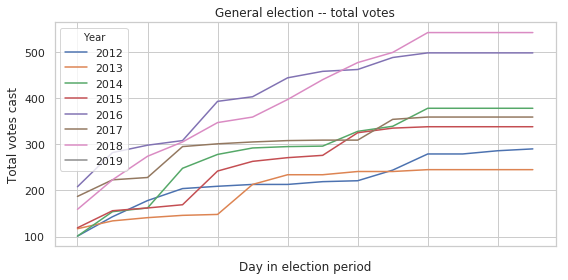

In [6]:
fig, axes = plt.subplots(figsize=(8,4))
generalData.T.plot(ax=axes)
axes.set_title("General election -- total votes")
axes.set_ylabel("Total votes cast"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
generalProport.T.plot(ax=axes)
axes.set_title("General election returns -- proportion of eligible voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Daily marginal votes cast

In [ ]:
generalMarginal = generalData.T.sub(generalData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
generalMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=generalMarginal.dropna(axis=1), ax=axes)
axes.set_title("General election - marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (generalMarginal.index.min(), generalMarginal.index.max()))
fig.tight_layout()

# Senate-elected positions election 

## Total votes cast

In [ ]:
senateData

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateData.T.plot(ax=axes)
axes.set_title("Senate-elected positions election --- total votes")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateProport.T.plot(ax=axes)
axes.set_title("Senate election returns -- proportion of eligible senate voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Votes cast per day

In [ ]:
senateMarginal = senateData.T.sub(senateData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
senateMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=senateMarginal.dropna(axis=1), ax=axes)
axes.set_title("Senate-elected positions -- marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (senateMarginal.index.min(), senateMarginal.index.max()))
fig.tight_layout()

# Election design and machinery

In [ ]:
ELECTION_YEAR = 2018
resultsFolder = "%s/Box Sync/Faculty Senate Collaborative Documents/Elections/Results/" % BASE
currentElection = "%s/%s Elections official results" % (resultsFolder, ELECTION_YEAR)
senateFolder = "%s/senate official results" % currentElection
generalFolder = "%s/general official results" % currentElection

In [ ]:
resultFileString = "Results.xlsx"
senateFiles = [f for f in makeDataFileList(senateFolder) if f[-12:] == resultFileString]
generalFiles = [f for f in makeDataFileList(generalFolder) if f[-12:] == resultFileString]
senateFrames = [pd.read_excel(f) for f in senateFiles]
generalFrames = [pd.read_excel(f) for f in generalFiles]

In [ ]:
def number_of_abstentions(frame):
    """Returns the number of blank ballots minus the
    number of write in votes"""
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
    abstentions = frame[frame[committeeName] == 'abstentions']['votes']
    abstentions = int(abstentions)
    # now we need to subtract the writeins
    # since any write-in will be  counted as an
    # abstention
    #
    # !!!!!!!!!!!!! todo double-check in code
    try:
        wi = frame[frame[committeeName] == 'writeins-unverified']['votes']
        wi = int(wi)        
        abstentions = abstentions + wi
    except:
        pass
    return (committeeName, abstentions)

def number_of_illegal_overselections(frame):
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
#     print(committeeName)
    v = frame[frame[committeeName] == 'illegal-overselection']['votes']
    v = int(v)
    return (committeeName, v)

def number_manually_disqualified(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    # get rid of any of the programmatically added columns
    v = frame.dropna()
    # add up the disqualified votes
    v = int(v.dq.sum())
    return (committeeName, v)

def number_illegal(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    #programmaticOverselections: too many boxes ticked
    po = number_of_illegal_overselections(frame)
    #write ins which invalidated the vote
    wi = number_manually_disqualified(frame)
    num =  po[1] + wi[1]
    return (committeeName, num)  

In [ ]:
def get_frame_for_plotting(func, columnName):
    v =  [func(frame) for frame in senateFrames]
    v =  v + [func(frame) for frame in generalFrames]
    return DataFrame(v, columns=['election', columnName]).set_index('election')

def plot_frame(frame, title, ylabel):
    fig, axes = plt.subplots(figsize=(8,3))
    frame.plot(kind='bar', table=True, ax=axes)
    x_axis = axes.get_xaxis(); axes.set_ylabel(ylabel)
    x_axis.set_visible(False); axes.set_title(title)
    fig.tight_layout()

In [ ]:
overselections = get_frame_for_plotting(number_of_illegal_overselections, 'over-selections')
plot_frame(overselections,  'Number ballots spoiled by too many candidates being selected', 'count')


## Write-in boxes


In [ ]:
dq = get_frame_for_plotting(number_manually_disqualified, 'disqualified')
plot_frame(dq,"Number of ballots disqualified due to write-ins", "# of ballots disqualified")

### Abstentions 


In [ ]:
abstentions = get_frame_for_plotting(number_of_abstentions, 'abstentions')
plot_frame(abstentions, "Number of blank ballots", "# of privations")

# Questions:
- How many votes were invalid because of the overselection (illegal-overselction + invalid) in each election?

- How many abstentions were there

In [ ]:
SENATE_VOTES = 50 #todo refer to value calculated above, just need election year
SENATE_ELLIGIBLE = 71 #todo refer to value calculated above, just need election year

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in generalFrames]
# illegalVotes = DataFrame(illegalVotes, columns=['Office', 'Illegal votes'])
#abstentions

In [ ]:
generalAbstentions =  [number_of_abstentions(frame) for frame in generalFrames]
generalAbstentions = DataFrame(generalAbstentions, columns=['Position', 'Abstentions'])


In [ ]:
abstentions

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in senateFrames]
illegalVotes = DataFrame(illegalVotes, columns=['election', 'Illegal votes'])
# these are included in illegal
overselections = [number_of_illegal_overselections(frame) for frame in senateFrames]
overselections = DataFrame(overselections, columns=['election', 'Overselections'])

data = pd.merge(left=abstentions, right=illegalVotes, on='election').set_index('election')

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
data.plot(kind='bar', ax=axes)
axes.set_title("Counts of abstentions and illegal votes for standing committee elections")
axes.set_ylabel("Count")
fig.tight_layout()

In [ ]:
pctEligible = data.copy(deep=True)
pctVoters = data.copy(deep=True)
pctVoters.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)
pctEligible.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)


pctEligible['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_ELLIGIBLE)
pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

pctVoters['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_VOTES)
pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

# pctEligible['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))
# pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))

# pctVoters['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_VOTES) * 100))
# pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE) * 100))

In [ ]:
fig, axes = plt.subplots(nrows=2)
pctEligible.plot(kind='bar', ax=axes[0])
axes[0].set_title("Abstentions and illegal votes as proportion of eligible voters")
axes[0].set_ylabel("count / # eligible ")
pctVoters.plot(kind='bar', ax=axes[1])
axes[1].set_ylabel("count / # case ")
axes[1].set_title("Abstentions and illegal votes as proportion of votes cast")
fig.tight_layout()